# Homework 1

## FINM 37400 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

This homework relies on the data file, `treasury_quotes_2022-09-30`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `ITYPE` of 11 or 12, as these indicate a TIPS Note or TIPS bond.

#### #Update as of Jan 7 at 3pm*

Find more info about many of the fields in the data set at the following link,

https://www.crsp.org/products/documentation/treasno-properties

Find the complete manual for the CRSP Treasury data at the following link,

https://www.crsp.org/files/treasury_guide_0.pdf

In [2]:
# raw = pd.read_excel("../data/treasury_quotes_2022-09-30.xlsx")
QUOTE_DATE = '2022-09-30'

filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

In [3]:
rawdata

,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,...,TFCALDT,TNOTICE,IYMCN,ITYPE,IUNIQ,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,20221004.400000,2022-09-30,99.973333,99.973444,99.973389,M,I,0.000000,-1.389258e-07,0.000067,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207774,20221006.400000,2022-09-30,99.960917,99.961083,99.961000,M,I,0.000000,-2.542594e-05,0.000065,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207893,20221011.400000,2022-09-30,99.924986,99.925292,99.925139,M,I,0.000000,1.473347e-05,0.000068,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207868,20221013.400000,2022-09-30,99.907556,99.907917,99.907736,M,I,0.000000,-8.270836e-05,0.000071,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207430,20221015.201370,2022-09-30,99.921875,99.953125,99.937500,M,I,0.631148,3.735728e-05,0.000079,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207808,20511115.101870,2022-09-30,65.914062,65.960938,65.937500,M,I,0.703125,-1.093971e-02,0.000104,...,NaN,0,NaN,1,0,1,1,NaN,NaN,NaN
207849,20520215.102250,2022-09-30,72.406250,72.468750,72.437500,M,I,0.281250,-1.044175e-02,0.000104,...,NaN,0,NaN,1,0,1,1,NaN,NaN,NaN
207850,20520215.C00120,2022-09-30,62.781250,63.039062,62.910156,M,I,0.000000,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN


In [4]:
data = rawdata[(rawdata["ITYPE"] != 11) & (rawdata["ITYPE"] != 12)].copy()
data

,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,...,TFCALDT,TNOTICE,IYMCN,ITYPE,IUNIQ,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,20221004.400000,2022-09-30,99.973333,99.973444,99.973389,M,I,0.000000,-1.389258e-07,0.000067,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207774,20221006.400000,2022-09-30,99.960917,99.961083,99.961000,M,I,0.000000,-2.542594e-05,0.000065,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207893,20221011.400000,2022-09-30,99.924986,99.925292,99.925139,M,I,0.000000,1.473347e-05,0.000068,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207868,20221013.400000,2022-09-30,99.907556,99.907917,99.907736,M,I,0.000000,-8.270836e-05,0.000071,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207430,20221015.201370,2022-09-30,99.921875,99.953125,99.937500,M,I,0.631148,3.735728e-05,0.000079,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207763,20510815.102000,2022-09-30,68.085938,68.148438,68.117188,M,I,0.250000,-1.043777e-02,0.000104,...,NaN,0,NaN,1,0,1,1,NaN,NaN,NaN
207808,20511115.101870,2022-09-30,65.914062,65.960938,65.937500,M,I,0.703125,-1.093971e-02,0.000104,...,NaN,0,NaN,1,0,1,1,NaN,NaN,NaN
207849,20520215.102250,2022-09-30,72.406250,72.468750,72.437500,M,I,0.281250,-1.044175e-02,0.000104,...,NaN,0,NaN,1,0,1,1,NaN,NaN,NaN


# Problem 1: Explore the Data

## 1 Maturity

For each issue, calculate its time-to-maturity, quoted in number of years, based on the issue and maturity dates. Assume a year has exactly 365.25 days.

In [5]:
t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None
t_current

numpy.datetime64('2022-09-30T00:00:00.000000000')

In [6]:
def get_maturity_delta(t_maturity, t_current):

    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')

    return maturity_delta

In [7]:
# TMATDT: maturity date
data['MATURITY'] = get_maturity_delta(data['TMATDT'], t_current)
data[["MATURITY"]].head()

,MATURITY
KYTREASNO,
207892,0.010951
207774,0.016427
207893,0.030116
207868,0.035592
207430,0.041068


In [8]:
data[["MATURITY"]].tail()

,MATURITY
KYTREASNO,
207763,28.873374
207808,29.125257
207849,29.377139
207891,29.623546
207934,29.875428


## 2 Prices 

Calculate the "dirty" price for each bond issue as
$$\text{price} = \frac{1}{2}(\text{TDBID} + \text{TDASK}) + \text{TDACCINT}$$
Namely, you are taking the midpoint of the bid and ask prices, and then you add the accrued interest.

In [9]:
data["price"] = 0.5 * (data["TDBID"] + data["TDASK"]) + data["TDACCINT"]
data[["price"]].head()

,price
KYTREASNO,
207892,99.973389
207774,99.961000
207893,99.925139
207868,99.907736
207430,100.568648


In [10]:
data[["price"]].tail()

,price
KYTREASNO,
207763,68.367188
207808,66.640625
207849,72.718750
207891,84.726562
207934,86.507812


## 3 YTM

#### #Update as of Jan 9, at 5pm.

Write a function to calculate the yield-to-maturity for each issue. You will need to use a nonlinear solver to solve for the YTM.

In [11]:
def get_coupon_dates(quote_date, maturity_date):
    
    # divide by 180 just to be safe
    temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
    # filter out if one date too many
    temp = pd.DataFrame(data=temp[temp > quote_date])

    out = temp[0]
    return out

def ytm_func(ytm, c, coupon_dates, price):
    res = ((1+ytm/2)**(-2*coupon_dates[-1]))*100 - price
    if c == 0:
        return res
    else:
        for t in coupon_dates:
            res += c/2*((1+ytm/2)**(-2*t))
        return res

In [12]:
for i in data.index:
    coupon_dates = get_coupon_dates(
        data.loc[i, 'CALDT'], data.loc[i, 'TMATDT'])
    time_delta = (coupon_dates - t_current).dt.days/365.25

    data.loc[i, "ytm"] = fsolve(ytm_func, 0, args=(
        data.loc[i, "TCOUPRT"], time_delta.values, data.loc[i, "price"]))[0]

In [13]:
data['TDYLD_annualize'] = data["TDYLD"] * 365
data[["TDYLD_annualize", "ytm"]]

,TDYLD_annualize,ytm
KYTREASNO,,
207892,0.024286,0.024451
207774,0.023730,0.023887
207893,0.024850,0.025022
207868,0.025917,0.026103
207430,0.028740,0.028968
...,...,...
207763,0.037968,0.038357
207808,0.037857,0.038243
207849,0.037800,0.038186


## 4 Summary Table

#### Correction: Jan 7, 3pm.
Field name was listed as `TDYTM` when it is actually `TDYLD`.
#### End correction

Create a dataframe with the following columns:


| maturity | price | coupon rate | ytm | TDYLD | bid-ask |
|----------|-------|-------------|-----|----------|---------|

where 
* `maturity` refers to the time-to-maturity
* `TDYLD` is the YTM calculated by the data provider

Use `describe()` in pandas to to show descriptive statistics for this dataframe.

In [14]:
metrics = data[["MATURITY", "price", 'TCOUPRT', 'ytm', 'TDYLD']].copy()
metrics.columns = [["maturity", "price", "coupon rate", "ytm", "TDYTM"]]
metrics["TDYTM"] = metrics["TDYTM"] * 365
metrics['bid-ask'] = data['TDBID'] - data['TDASK']
metrics.describe()

,maturity,price,coupon rate,ytm,TDYTM,bid-ask
count,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000
mean,6.204549,93.605188,1.886905,0.039846,0.039407,-0.039184
std,7.998196,9.119944,1.594043,0.004290,0.004203,0.021349
min,0.010951,56.304688,0.000000,0.023887,0.023730,-0.164444
25%,0.884326,88.692383,0.406250,0.038640,0.038246,-0.046875
50%,2.854209,96.023268,1.750000,0.041197,0.040750,-0.039062
75%,6.405886,98.933016,2.750000,0.042865,0.042347,-0.031250
max,29.875428,117.296875,7.625000,0.044070,0.043562,-0.000111


## 5 Plots

Create a scatter plot of maturity versus price for all issues.

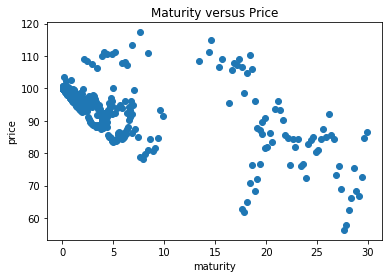

In [15]:
plt.scatter(metrics["maturity"], metrics["price"])
plt.xlabel('maturity')
plt.ylabel('price')
plt.title('Maturity versus Price')
plt.show()

## 6 Bad Data?

Find the issues where `TDYTM` is `NaN`. Display these rows from your table above. How many issues (rows) are effected?

What do you see in the other metrics for these issues that suggests that the price is bad?

**Answers:** As seen below, if we are using rawdata(with TIPS), 49 rows have TDYLD as NaN. The ITYPE of all of these issues is either 11 or 12, indicating that they are all TIPS (11= Inflation-Adjusted Bonds, 12 = Inflation-Adjusted Notes).

In [16]:
metrics["TDYTM"].isnull().sum()

TDYTM    0
dtype: int64

In [17]:
rawdata[rawdata["TDYLD"].isnull()]


,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,...,TFCALDT,TNOTICE,IYMCN,ITYPE,IUNIQ,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
206582,20230115.C00120,2022-09-30,98.984375,98.992188,98.988281,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
207204,20230415.C00620,2022-09-30,98.613281,98.621094,98.617188,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
206642,20230715.C00370,2022-09-30,98.382812,98.394531,98.388672,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
206701,20240115.C00620,2022-09-30,97.609375,97.628906,97.619141,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
207348,20240415.C00500,2022-09-30,97.109375,97.132812,97.121094,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
206759,20240715.C00120,2022-09-30,96.503906,96.527344,96.515625,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
207431,20241015.C00120,2022-09-30,96.054688,96.085938,96.070312,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
206468,20250115.B02370,2022-09-30,100.253906,100.285156,100.269531,M,I,0.0,NaN,NaN,...,NaN,0,NaN,11,0,1,1,NaN,NaN,NaN
206816,20250115.C00250,2022-09-30,95.593750,95.625000,95.609375,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN


# Problem 2: Extract the Discount Curve

## 1 Map Cashflows

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

You will need to make a few modeling choices to do this...
* eliminate any treasury that does not report `TDYTM` or that reports a negative number for `TDYTM`.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

**Answers:** 2023-01-31

* which date has the most issues paying a cashflow?

**Answers:** 2023-02-15


In [18]:
def calc_cashflows(quote_data, filter_maturity_dates=False):

    CF = pd.DataFrame(data=0, index=quote_data.index,
                      columns=quote_data['TMATDT'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(
            quote_data.loc[i, 'CALDT'], quote_data.loc[i, 'TMATDT'])

        if coupon_dates is not None:
            CF.loc[i, coupon_dates] = quote_data.loc[i, 'TCOUPRT']/2

        CF.loc[i, quote_data.loc[i, 'TMATDT']] += 100

    CF = CF.fillna(0).sort_index(axis=1)
    CF.drop(columns=CF.columns[(CF == 0).all()], inplace=True)

    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)

    return CF

In [19]:
CF = calc_cashflows(data)

In [20]:
CFset = {'all dates, including negative YTM quotes': CF}
display(CF)

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207774,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207893,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207868,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207430,0,0,0,0,100.6875,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207763,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.000,0.0000,1.000,0.0000,101.000,0.0000,0.000,0.0000,0.0
207808,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.9375,0.000,0.9375,0.000,0.9375,0.000,100.9375,0.000,0.0000,0.0
207849,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.125,0.0000,1.125,0.0000,1.125,0.0000,101.125,0.0000,0.0


In [21]:
CF.head()

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207774,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207893,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207868,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207430,0,0,0,0,100.6875,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
CF.tail()

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207763,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0000,1.000,0.0000,1.000,0.0000,101.000,0.0000,0.000,0.0000,0.0
207808,0,0,0,0,0.0,0,0,0,0,0.0,...,0.9375,0.000,0.9375,0.000,0.9375,0.000,100.9375,0.000,0.0000,0.0
207849,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0000,1.125,0.0000,1.125,0.0000,1.125,0.0000,101.125,0.0000,0.0
207891,0,0,0,0,0.0,0,0,0,0,0.0,...,1.4375,0.000,1.4375,0.000,1.4375,0.000,1.4375,0.000,101.4375,0.0
207934,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0000,1.500,0.0000,1.500,0.0000,1.500,0.0000,1.500,0.0000,101.5


In [23]:
print("Most cash flow: " + datetime.datetime.strftime(CF.sum(axis=0).idxmax(), "%Y-%m-%d"))

Most cash flow: 2023-01-31


In [24]:
print("Most issues paying: " +
      datetime.datetime.strftime(CF.astype(bool).sum(axis=0).idxmax(), "%Y-%m-%d"))

Most issues paying: 2023-02-15


## 2 Bootstrap

Bootstrap the discount factors.

Starting with $C$ from the previous problem, further filter to create a subset of Treasury issues cashflow matrix $\tilde{C}$, such that each column has one, and only one, maturity. Also, each issue (row) has its face value payment in one of the columns.

The three step procedure below might be useful.

1. For dates with multiple bonds maturing, keep only that with the smallest bid-ask. If there are still multiple bonds maturing on the date, keep only that with the smallest coupon.

2. Only keep the first $L$ columns of the cashflow matrix, such that every column has a bond maturing.

3. Eliminate any bonds, (rows,) that had maturity beyond column $L$.

This should produce the cashflow matrix, $\tilde{C}$.

**Report 5 head and tail rows of $\tilde{C}$.**

Solve the system of equations
$$\textbf{p} = \tilde{\textbf{C}}\, \textbf{z}_{\text{bootstrap}}$$

**Plot the estimated discount factors, $\textbf{z}$, against time-to-maturity.**

In [25]:
data['bid-ask'] = np.abs(data['TDBID'] - data['TDASK'])
filtered_data = data.sort_values(['TMATDT', 'bid-ask'], ascending=True)
filtered_data = filtered_data.drop_duplicates(subset=["TMATDT"], keep="first")
filtered_data

,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,...,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT,MATURITY,price,ytm,TDYLD_annualize,bid-ask
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,20221004.400000,2022-09-30,99.973333,99.973444,99.973389,M,I,0.000000,-1.389258e-07,0.000067,...,1,1,NaN,NaN,NaN,0.010951,99.973389,0.024451,0.024286,0.000111
207774,20221006.400000,2022-09-30,99.960917,99.961083,99.961000,M,I,0.000000,-2.542594e-05,0.000065,...,1,1,NaN,NaN,NaN,0.016427,99.961000,0.023887,0.023730,0.000167
207893,20221011.400000,2022-09-30,99.924986,99.925292,99.925139,M,I,0.000000,1.473347e-05,0.000068,...,1,1,NaN,NaN,NaN,0.030116,99.925139,0.025022,0.024850,0.000306
207868,20221013.400000,2022-09-30,99.907556,99.907917,99.907736,M,I,0.000000,-8.270836e-05,0.000071,...,1,1,NaN,NaN,NaN,0.035592,99.907736,0.026103,0.025917,0.000361
207430,20221015.201370,2022-09-30,99.921875,99.953125,99.937500,M,I,0.631148,3.735728e-05,0.000079,...,1,1,NaN,NaN,NaN,0.041068,100.568648,0.028968,0.028740,0.031250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207763,20510815.102000,2022-09-30,68.085938,68.148438,68.117188,M,I,0.250000,-1.043777e-02,0.000104,...,1,1,NaN,NaN,NaN,28.873374,68.367188,0.038357,0.037968,0.062500
207808,20511115.101870,2022-09-30,65.914062,65.960938,65.937500,M,I,0.703125,-1.093971e-02,0.000104,...,1,1,NaN,NaN,NaN,29.125257,66.640625,0.038243,0.037857,0.046875
207849,20520215.102250,2022-09-30,72.406250,72.468750,72.437500,M,I,0.281250,-1.044175e-02,0.000104,...,1,1,NaN,NaN,NaN,29.377139,72.718750,0.038186,0.037800,0.062500


In [26]:

def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):

    mask_benchmark_dts = []
    
    # Filter by using only benchmark treasury dates
    for col in CF.columns:
        if filter_benchmark_dates:
            if col.month in [2,5,8,11] and col.day == 15:
                mask_benchmark_dts.append(col)
        else:
            mask_benchmark_dts.append(col)
    
    if filter_maturity_dates:
        mask_maturity_dts = CF.columns[(CF>=100).any()]
    else:
        mask_maturity_dts = CF.columns
    
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # drop issues that had CF on excluded dates
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]

    else:
        # drop issues that have no CF on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
        
    # update to drop dates with no CF
    CF_filtered = CF_filtered.loc[:,(CF_filtered>0).any()]
    
    return CF_filtered

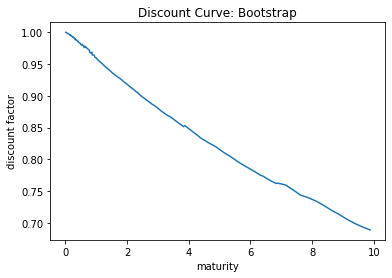

In [27]:
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = True

# model_data = filter_treasuries(data, t_date=t_current, filter_yld=RESTRICT_YLD,
#                          filter_tips=RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
model_data = filtered_data
CF = filter_treasury_cashflows(calc_cashflows(
    model_data), filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = data.loc[CF.index, "price"]
params_boot = estimate_rate_curve(MODEL, CF, t_current, prices)

label = 'single maturity per date, no non-maturity dates'
CFset[label] = CF

plt.plot(params_boot[0], params_boot[1])
plt.xlabel('maturity')
plt.ylabel('discount factor')
plt.title('Discount Curve: Bootstrap')
plt.show()

## 3. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. (You might do something similar to the three-step procedure of the bootstrap, but skip step #1.) Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

**Plot the discount factors against maturities.**

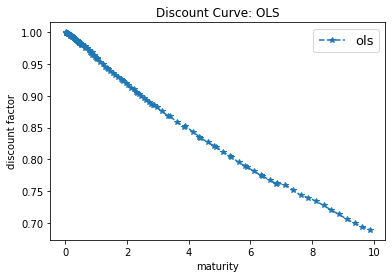

In [28]:
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = False

model_data = filtered_data
CF = filter_treasury_cashflows(calc_cashflows(
    model_data), filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = data['price'][CF.index]
params_OLS = estimate_rate_curve(MODEL, CF, t_current, prices)

label = 'no non-maturity dates'
CFset[label] = CF

disc_ols = pd.DataFrame(
    {'maturity': params_OLS[0], 'ols': params_OLS[1]}).set_index('maturity')
disc_ols.plot(marker='*', linestyle='--',
              ylabel='discount factor', title='Discount Curve: OLS')
plt.show()


## 4 Factors and Rates

Convert $\textbf{z}_{\text{bootstrap}}$ to a set of 
* continuous discount rates
* semiannually compounded discount rates

Do the same for $\textbf{z}_{\text{ols}}$.

Plot the **continuous** discount rates generated via bootstrap and via OLS against time-to-maturity.

Plot the **semiannually compounded** discount rates generated via bootstrap and via OLS against time-to-maturity.

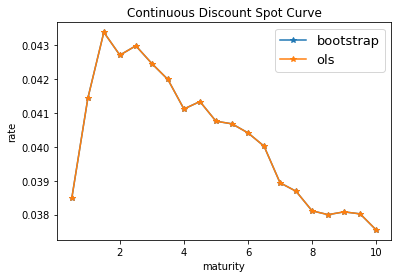

In [32]:
inc = .5

maturity_grid = np.arange(inc, disc_ols.index.to_series().max()+.5, inc)
curves_ols = pd.DataFrame(index=maturity_grid)
curves_ols['bootstrap'] = bootstrap(params_boot, maturity_grid)
curves_ols['ols'] = bootstrap(params_OLS, maturity_grid)

ax = curves_ols.plot(linestyle='-', marker='*', ylabel='rate',
                     xlabel='maturity', title='Continuous Discount Spot Curve')
plt.show()

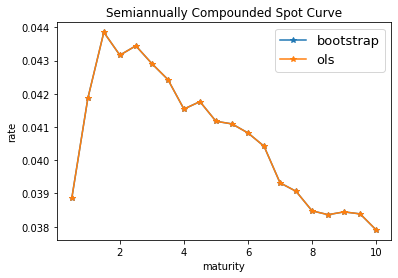

In [31]:
inc = .5

maturity_grid = np.arange(inc, disc_ols.index.to_series().max()+.5, inc)
curves_ols = pd.DataFrame(index=maturity_grid)
curves_ols['bootstrap'] = bootstrap(params_boot, maturity_grid, 2)
curves_ols['ols'] = bootstrap(params_OLS, maturity_grid, 2)

ax = curves_ols.plot(linestyle='-', marker='*', ylabel='rate',
                     xlabel='maturity', title='Semiannually Compounded Spot Curve')
plt.show()